<a href="https://colab.research.google.com/github/sergey-jr/F19-20_ML/blob/master/Final_Exam_Sergei_Bakaleinik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Advanced Machine Learning **[Final Exam (Practical)]**
## Innopolis University 
### Date: 20 May 2020 
### Duration: 1 hour
Total Points: 100

<!-- ***There are 4 TODO CHUNKS look for them and fill the code accordingly.***



Transfer Learning  = 10 POINTS (50%)
EXPLAINABLE ML  = 10 POINTS (50%) -->

# **Task**
##### The task you are required to use a pretrained model to make a binary classifier for bees and ants and make interpretation.

### Required Libraries

In [ ]:
!pip install lime
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from skimage.segmentation import mark_boundaries

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

# License: BSD
# Author: Sasank Chilamkurthy
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


### Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
from os import path
if not path.exists("hymenoptera_data"):
    !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
    !unzip hymenoptera_data.zip

# Task 1: Augmentation **[20 Points]**
---------

Add the following augmentations

*   Random rotations
*   Add Noise
*   Random Horrizental Flip







In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        ###############################################
        ######        your code goes here  ############   
        ###############################################
        # TODO: Add 3 more transformations
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        AddGaussianNoise(0, 0.025),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
###############################################
######        your code goes here  ############   
###############################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# TODO: select the device depending on the existance of GPU 

 [Check Point]. Task 1
-----------------
Let's visualize a few training images so as to understand the data
augmentations.



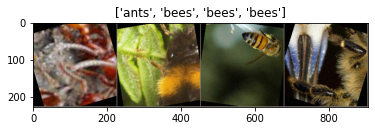

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Task 2: Train Model **[20 Points]**
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    ###############################################
                    ######        your code goes here  ############   
                    ###############################################
                    outputs = model(inputs)#TODO: pass the inputs through the model 


                    ###############################################
                    ######        your code goes here  ############   
                    ###############################################
                    loss = criterion(outputs, labels)#TODO: Calcualte the loss between the outputs and real labels 
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    ###############################################
    ######        your code goes here  ############   
    ###############################################
    # TODO: load best model weights from the best_model_wts variable.
    model.load_state_dict(best_model_wts)
    return model

[Check Point]. Task 2
--------------------

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Task 3:  Fixed Feature Extractor **[30 Points]**
----------------------------------

Here, we need to freeze all the network except the final layers. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.





In [ ]:
def make_model():
    ###############################################
    ######        your code goes here  ############   
    ###############################################
    # TODO: Use a pretrained resnet 18 
    # TODO: Freeze the layers of the model and change the final layers to fit our needs 

    model_conv = models.resnet18(pretrained=True, progress=True)
    for param in model_conv.parameters():
      param.requires_grad = False
    model_conv.trainable = False
    model_conv.fc = torch.nn.Linear(512, 10)
    
    return model_conv

model_conv = make_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

[Check Point] Task 3
---------------------

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8155 Acc: 0.6066
val Loss: 1.0304 Acc: 0.6013

Epoch 1/24
----------
train Loss: 0.5091 Acc: 0.7746
val Loss: 0.2781 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5855 Acc: 0.7623
val Loss: 0.5525 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.5309 Acc: 0.7459
val Loss: 0.2658 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5923 Acc: 0.7459
val Loss: 0.3664 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4610 Acc: 0.7746
val Loss: 0.2818 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3382 Acc: 0.8525
val Loss: 0.2948 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3844 Acc: 0.8361
val Loss: 0.2859 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.4729 Acc: 0.7746
val Loss: 0.3864 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3567 Acc: 0.8443
val Loss: 0.2751 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3316 Acc: 0.8361
val Loss: 0.3411 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3262 Acc: 0.8525
val Loss: 0.2952 Acc: 0.9020

Epoch 12/24
----------
t

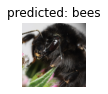

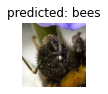

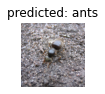

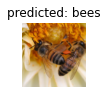

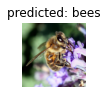

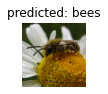

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

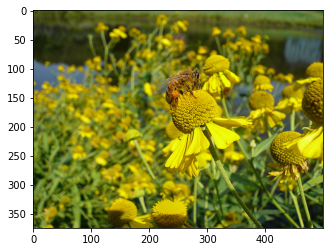

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/content/hymenoptera_data/val/bees/1355974687_1341c1face.jpg')
plt.imshow(img)

In [ ]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

# Task 4: Class Probabilities **[30 points]**
---------------

Print the probabilities for the image for each one of the classes and find the idx to class mapping chosen by the dataloader.

You must use the dataloader to access this information.

In [ ]:
###############################################
######        your code goes here  ############   
###############################################
def get_probabilities(img):
    # TODO : send img though the model and remember it is being evaluated so make the needed changes to the model.
    # return: the probabilities for each class for the specific image
    class_idx = {0: 'ants', 1: 'bees'}# dict idx:class_name
    idx2label = [class_idx[k] for k in range(len(class_idx))]
    cls2label = {class_idx[k]: class_idx[k] for k in range(len(class_idx))}
    cls2idx = {class_idx[k]: k for k in range(len(class_idx))}
    input_tens = get_input_tensors(img)
    probs = model_conv(input_tens.to(device))
    probabilities = {'class1': probs[0][0].data.item(),'class2':probs[0][1].data.item()}
    return probabilities, class_idx, idx2label, cls2label, cls2idx


[Check Point]. Task 4
--------------------

Printing the probailities and the class_idx


In [ ]:
probabilities, class_idx, idx2label, cls2label, cls2idx = get_probabilities(img)
probabilities, class_idx

({'class1': 5.413920879364014, 'class2': 10.236010551452637},
 {0: 'ants', 1: 'bees'})

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model_conv.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_conv.to(device)
    batch = batch.to(device)
    
    logits = model_conv(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

1

# Bonus Task: Task Description **[10 Points]**
--------------
These points are provide if your score is less the 100. Attempt to this part is completely option.

In [ ]:
###############################################
######        your code goes here  ############   
###############################################

def vizuliaze_model_decisions():
    # TODO: Create the image explained and use it to explain our image decision why did it make each decision for each class. 
    # Visulize the explanation with boundries
    # add a small comment on how the model is performing and did it make an error for other class. 
    img_with_decision_boundries = None


    return img_with_decision_boundries
plt.imshow(vizuliaze_model_decisions())